In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [3]:
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

'''
label = 0: front, 1:backward, 2:right, 3:dance
'''

# The directories and the corresponding labels
directories = [os.path.join(".", "output_front"), os.path.join(".", "output_bw"), 
               os.path.join(".", "output_right"), os.path.join(".", "output_dance")]
labels = [0, 1, 2, 3]  # Change this to your actual labels

datasets = []  # List to store datasets from each directory

for directory, label in zip(directories, labels):
    # Get all subdirectories
    subdirs = [f.path for f in os.scandir(directory) if f.is_dir()]
    subdirs.sort()

    # Create an empty 3D array to store the combined data
    combined_arr = np.zeros((len(subdirs), 1000, 10))  # Use np.zeros instead of np.empty

    for i, subdir in enumerate(subdirs):
        # Load the action and obs CSV files
        action_df = pd.read_csv(os.path.join(subdir, "action.csv"), header=None)
        obs_df = pd.read_csv(os.path.join(subdir, "obs.csv"), header=None)

        # Concatenate the DataFrames horizontally and convert to a 3D array
        combined_data = pd.concat([action_df, obs_df], axis=1)
        combined_arr[i] = np.reshape(combined_data.values, (1000, 10))  # Use i instead of i-1

        # Convert to tensor and add a dimension for the batch size
        combined_tensor = torch.from_numpy(combined_arr[i]).unsqueeze(0)

        # Create a TensorDataset and append it to the list
        datasets.append(TensorDataset(combined_tensor, torch.tensor([label])))

# Concatenate all datasets
dataset = ConcatDataset(datasets)

In [4]:
# View the first sample in the dataset
first_sample = dataset[0]

# `first_sample` is a tuple where the first element is the input tensor and the second element is the label
print("Input:", first_sample[0])
print("Label:", first_sample[1])


Input: tensor([[-1.0000,  1.0000, -0.0565,  ...,  1.6270, -3.3524,  3.4771],
        [-0.6543, -0.9889,  0.0079,  ...,  1.6177, -2.6683,  1.5213],
        [-0.9437, -0.9956,  0.0796,  ...,  1.9437, -2.6980,  0.2924],
        ...,
        [-0.7277, -1.0000, -0.4425,  ...,  1.6512, -2.9347,  1.1169],
        [-0.9949, -1.0000, -0.3696,  ...,  1.9771, -3.1826,  0.3716],
        [-1.0000, -1.0000,  0.0715,  ...,  0.0083, -0.0401, -0.0155]],
       dtype=torch.float64)
Label: tensor(0)


In [5]:
# output_dir = os.path.join(".", "output_right")

# subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
# subdirs.sort()

# # Create an empty 3D array to store the combined data
# combined_arr = np.empty((len(subdirs), 1000, 10))

# # Loop through each subdirectory and load the CSV files
# for i, subdir in enumerate(subdirs):
#     action_filename = os.path.join(subdir, "action.csv")
#     obs_filename = os.path.join(subdir, "obs.csv")

#     # Load the action and obs CSV files
#     action_df = pd.read_csv(action_filename,  header=None)
#     obs_df = pd.read_csv(obs_filename,  header=None)

#     # Concatenate the DataFrames horizontally
#     combined_data = pd.concat([action_df, obs_df], axis=1)

#     # Convert combined_data to a 3D array and assign it to combined_arr
#     combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# # Print the shape of combined_arr
# print(combined_arr.shape)
# combined_tensor = torch.from_numpy(combined_arr)

In [6]:
combined_tensor[0]

tensor([[ 1.0000, -1.0000,  0.6781,  ..., -0.7489,  1.4353, -1.4702],
        [-0.1574, -1.0000,  0.5730,  ..., -0.6363,  1.4276, -1.8141],
        [-0.4205, -1.0000,  0.4961,  ..., -0.3885,  1.1517, -1.8559],
        ...,
        [ 1.0000,  0.4400,  0.5365,  ..., -1.3031,  1.6276,  0.3224],
        [ 1.0000,  0.5124,  0.3392,  ..., -1.3110,  1.6186,  0.3899],
        [ 1.0000,  0.6985,  0.7958,  ..., -0.0178, -0.0402,  0.0261]],
       dtype=torch.float64)

In [ ]:
# for i in range(len(dataset)):
#     data_from_dataset, label = dataset[i]
#     if label == 0:  # If the label is 0
#         data_from_tensor = combined_tensor[i]
#         if not torch.all(torch.eq(data_from_dataset, data_from_tensor)):
#             print(f"Data at index {i} does not match")
#             break
# else:
#     print("All data match")


In [ ]:
# # Flag to indicate if all data match
# all_data_match = True

# for i in range(len(dataset)):
#     data_from_dataset, label = dataset[i]
#     if label == 2:  # If the label is 0
#         match_found = False
#         for j in range(len(combined_tensor)):  # Iterate through all data in combined_tensor
#             data_from_tensor = combined_tensor[j]
#             if torch.all(torch.eq(data_from_dataset, data_from_tensor)):
#                 match_found = True
#                 break
#         if not match_found:  # If no match is found for this item
#             all_data_match = False
#             break

# if all_data_match:
#     print("OK")
# else:
#     print("Error")


In [ ]:
# import torch

# combined_tensor = torch.from_numpy(combined_arr)
# print(combined_tensor.shape)
# flattened_tensor = combined_tensor.permute(2, 0, 1).flatten(start_dim=1)

# print(flattened_tensor.shape)


# VAE code -1

====> Epoch: 1 Average loss: 0.006629359602928162, Recon Loss: 0.002674045490367072, KL Div: 0.01977657014983041
====> Epoch: 2 Average loss: 0.0039806618349892756, Recon Loss: 0.0026705598405429294, KL Div: 0.006550509861537389
====> Epoch: 3 Average loss: 0.0030324301166193826, Recon Loss: 0.0026643793497766765, KL Div: 0.001840253798024995
====> Epoch: 4 Average loss: 0.002786965148789542, Recon Loss: 0.0026560190873486655, KL Div: 0.0006547302039606231
====> Epoch: 5 Average loss: 0.002700057131903512, Recon Loss: 0.0026446010725838798, KL Div: 0.00027728031682116644
====> Epoch: 6 Average loss: 0.0026545286008289883, Recon Loss: 0.0026284617951938083, KL Div: 0.00013033402072531837
====> Epoch: 7 Average loss: 0.002617569374186652, Recon Loss: 0.0026028741896152495, KL Div: 7.347593988691058e-05
====> Epoch: 8 Average loss: 0.0025784745940140314, Recon Loss: 0.002569276830979756, KL Div: 4.598878856216158e-05
====> Epoch: 9 Average loss: 0.002535212857382638, Recon Loss: 0.0025289

====> Epoch: 71 Average loss: 0.002371299594640732, Recon Loss: 0.0023670632328305925, KL Div: 2.1181751574788776e-05
====> Epoch: 72 Average loss: 0.0023686682752200533, Recon Loss: 0.002367407692330224, KL Div: 6.302983633109502e-06
====> Epoch: 73 Average loss: 0.002367824239390237, Recon Loss: 0.0023674227978502, KL Div: 2.0072566611426218e-06
====> Epoch: 74 Average loss: 0.0023675237255437035, Recon Loss: 0.002367128069911684, KL Div: 1.978356923375811e-06
====> Epoch: 75 Average loss: 0.002366277247667313, Recon Loss: 0.0023660037091800144, KL Div: 1.3676743422235762e-06
====> Epoch: 76 Average loss: 0.002367547401360103, Recon Loss: 0.0023671952188014985, KL Div: 1.7608489309038434e-06
====> Epoch: 77 Average loss: 0.0023671697676181792, Recon Loss: 0.002366887778043747, KL Div: 1.4099233916827612e-06
====> Epoch: 78 Average loss: 0.002367853654282434, Recon Loss: 0.0023671182990074157, KL Div: 3.6766890968595234e-06
====> Epoch: 79 Average loss: 0.0023676087558269503, Recon Lo

====> Epoch: 141 Average loss: 0.0023674838713237216, Recon Loss: 0.0023669278706823075, KL Div: 2.780006400176457e-06
====> Epoch: 142 Average loss: 0.002367734670639038, Recon Loss: 0.002367106467485428, KL Div: 3.14100193125861e-06
====> Epoch: 143 Average loss: 0.0023671777418681553, Recon Loss: 0.002366868283067431, KL Div: 1.5472822955676487e-06
====> Epoch: 144 Average loss: 0.0023669525257178714, Recon Loss: 0.0023665266931056977, KL Div: 2.1291875413485938e-06
====> Epoch: 145 Average loss: 0.0023678980938025883, Recon Loss: 0.002367489550794874, KL Div: 2.042718231678009e-06
====> Epoch: 146 Average loss: 0.002367670842579433, Recon Loss: 0.0023670377390725274, KL Div: 3.165513277053833e-06
====> Epoch: 147 Average loss: 0.0023676869400909967, Recon Loss: 0.0023672470152378083, KL Div: 2.1995561463492258e-06
====> Epoch: 148 Average loss: 0.002368745139666966, Recon Loss: 0.002366834176438195, KL Div: 9.554871491023473e-06
====> Epoch: 149 Average loss: 0.002368363354887281, 

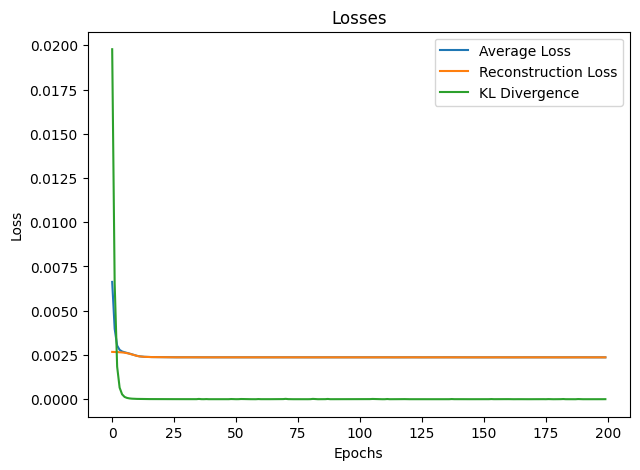

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
# dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 512  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 128  # modify as needed
hidden_dim2 = 64  # modify as needed
hidden_dim3 = 24  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 200  # modify as needed
beta = 0.2
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, (batch_data, batch_labels) in enumerate(train_loader):  # using train_loader instead of dataloader
#         batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

    
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, (batch_data, _) in enumerate(dataloader):  # batch_data와 레이블을 분리합니다.
            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div


evaluate(model, loss_fn, test_loader)

# latent space plot

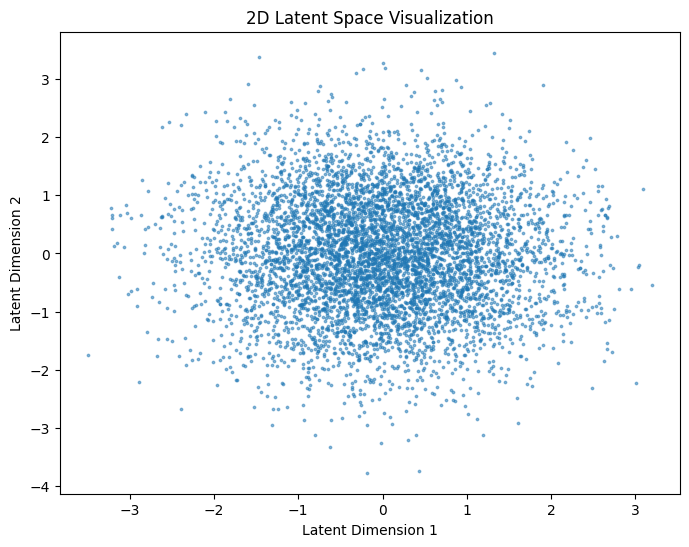

In [8]:
# Get latent space representations for all data points
latent_vectors = []
model.eval()
with torch.no_grad():
    for batch_data, _ in test_loader: # batch_data와 레이블을 분리합니다.
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        mu, log_var = model.encoder(batch_data)
        z = model.reparameterize(mu, log_var)
        latent_vectors.append(z)

dance_latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

# Plot the data in 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(dance_latent_vectors[:, 0], dance_latent_vectors[:, 1], alpha=0.5, s=3)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.show()



In [ ]:
with torch.no_grad():
    for batch in test_loader:
#         batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        mu, log_var = model.encoder(batch_data)
        print("mu is ", mu)
        print("log_var is ", log_var)

In [ ]:
def plot_latent(vae, data_loader, num_batches=100):
    vae.eval()  # Set the VAE model to evaluation mode
    all_z = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch.view(batch.size(0), -1)  # Flatten the data

            mu, log_var = vae.encoder(x)
            z = vae.reparameterize(mu, log_var)

            all_z.append(z)

            if i >= num_batches:
                break

    all_z = torch.cat(all_z, dim=0).cpu().numpy()

    plt.scatter(all_z[:, 0], all_z[:, 1], cmap='tab10')
    plt.colorbar()
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


plot_latent(model, test_loader)

In [ ]:
def plot_latent(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    latents = []
    for i, batch in enumerate(data_loader):
        x = batch  # Get only the data (ignore the label)
        x = x.view(x.size(0), -1)
        mu, log_var = model.encoder(x)
        z = model.reparameterize(mu, log_var)
        latents.append(z.detach().cpu().numpy())
    latents = np.concatenate(latents, axis=0)
    plt.figure(figsize=(7,5))
    plt.scatter(latents[:, 0], latents[:, 1], s=2)
    plt.colorbar()
    plt.show()

# Call the function to plot latent representations
plot_latent(model, test_loader)


# render with action

In [9]:

import torch

# Convert combined_arr to PyTorch Tensor
# combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

import matplotlib.pyplot as plt
from IPython import display
import gym


def replay(combined_data):

    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v3', render_mode = 'human')

    # Iterate through the rows
    for i in range(len(action_sp)):
        # Get the i-th row
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]
#         print(action)

        # If this is the first iteration, set the environment state to the given observation
        # Note: This assumes that the observation you've stored is the entire state that can be set with `env.reset()`
        # If this is not the case, you cannot simply set the environment state to the observation
        if i == 0:
            env.reset()  # We ignore the initial observation returned by `reset`

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        # Render the environment
        env.render()
        # If you want to slow down each step for viewing, you can use time.sleep
        time.sleep(0.01)

    # Close the environment
    env.close()


torch.Size([1, 1000, 10])


# see the output

In [25]:
from collections import defaultdict
import pandas as pd

def test_model(model, test_loader):
    model.eval()
    
    # 각 레이블에 대한 원본 및 재구성 데이터 프레임을 저장합니다.
    original_dfs = defaultdict(list)
    reconstructed_dfs = defaultdict(list)

    with torch.no_grad():
        for i, (batch_data, batch_labels) in enumerate(test_loader):
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()
            reconstructed_batch, _, _ = model(batch_data)

            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()
            labels = batch_labels.detach().cpu().numpy()

            # 각 레이블에 대해 데이터 프레임을 생성하고 저장합니다.
            for label, orig, recon in zip(labels, original_data, reconstructed_data):
                original_dfs[label].append(pd.DataFrame(orig.reshape(1, -1)))
                reconstructed_dfs[label].append(pd.DataFrame(recon.reshape(1, -1)))

    # 각 레이블의 데이터 프레임을 연결합니다.
    for label in original_dfs.keys():
        original_dfs[label] = pd.concat(original_dfs[label])
        reconstructed_dfs[label] = pd.concat(reconstructed_dfs[label])

    return original_dfs, reconstructed_dfs

# 훈련 후 함수를 호출합니다.
original_dfs, reconstructed_dfs = test_model(model, test_loader)

# 예를 들어 레이블 1에 대한 원본 및 재구성된 데이터를 가져옵니다.
label1_original_df = original_dfs[3]
label1_reconstructed_df = reconstructed_dfs[3]


In [11]:
label1_original_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-1.000000,1.000000,0.030901,-0.136987,0.088301,0.011968,-1.636022,1.520982,-3.339817,3.432855,...,-0.518726,0.687649,0.071707,-0.069952,0.027620,-0.090588,0.010912,-0.092796,0.018782,-0.033356
0,-1.000000,1.000000,0.006225,-0.161785,0.078798,-0.180959,-1.658178,1.670466,-3.312160,3.480664,...,-1.000000,-1.000000,0.026165,-0.019926,-0.093250,0.094216,-0.090759,-0.041420,-0.033330,-0.013809
0,-1.000000,1.000000,0.087359,-0.076853,0.097463,0.080257,-1.738002,1.642650,-3.355969,3.457327,...,0.994159,1.000000,0.054214,-0.082745,-0.082930,-0.055193,0.026591,-0.054185,-0.069990,-0.028266
0,-1.000000,1.000000,0.072860,-0.163066,0.110990,-0.013914,-1.661107,1.594515,-3.432756,3.493479,...,-0.994202,-0.677696,0.060651,0.055354,0.027880,0.079043,-0.005703,0.094885,-0.004379,0.022006
0,-1.000000,1.000000,0.062601,-0.160325,0.167947,0.053599,-1.638010,1.583700,-3.393496,3.464964,...,-0.885069,1.000000,0.057031,0.012723,-0.051842,0.079083,-0.073297,-0.047161,0.044267,-0.053493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-1.000000,1.000000,-0.043470,-0.054184,0.046163,-0.022959,-1.633883,1.681076,-3.384255,3.477615,...,-0.994936,-0.999999,-0.076907,0.028191,0.088256,0.018185,-0.017329,0.029900,-0.005883,-0.021901
0,-1.000000,1.000000,-0.005738,-0.003264,0.135476,-0.117800,-1.781893,1.556988,-3.448143,3.439797,...,-0.518725,0.687649,0.022650,-0.030252,-0.018737,0.026059,-0.034013,-0.062163,-0.084449,-0.096211
0,0.796969,-0.304304,0.053550,0.093747,-0.005411,-0.191691,1.092446,-1.198622,2.136496,-1.727975,...,0.999994,0.999994,-0.052894,0.073111,0.070421,-0.021298,0.011200,0.065759,-0.072403,0.090328
0,-1.000000,1.000000,0.064126,0.005442,0.101689,0.158757,-1.762883,1.599632,-3.474996,3.476257,...,1.000000,1.000000,0.086497,-0.052453,0.059431,0.062921,0.083789,0.022583,0.005463,0.068149


In [12]:
label1_reconstructed_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.518993,-0.419902,0.284620,-0.487180,0.481993,0.047966,0.379685,-0.246037,0.240292,-0.255817,...,-0.160305,-0.465326,0.320739,-0.547647,0.524951,0.060529,0.003173,0.000489,-0.002110,0.001281
0,0.518526,-0.433606,0.304541,-0.520922,0.474256,0.039251,0.400442,-0.255469,0.231789,-0.255058,...,-0.161065,-0.472154,0.330999,-0.570633,0.536978,0.060117,0.003266,0.001961,-0.002316,0.000106
0,0.516416,-0.434235,0.295718,-0.503277,0.478479,0.042195,0.388964,-0.252427,0.235386,-0.246902,...,-0.157835,-0.472469,0.330709,-0.568480,0.535902,0.062793,0.003547,0.001232,-0.002098,0.001660
0,0.515011,-0.424274,0.296713,-0.508026,0.473488,0.048085,0.385855,-0.248181,0.242219,-0.246193,...,-0.165407,-0.464122,0.321309,-0.546028,0.523156,0.066805,-0.000873,0.001047,-0.005943,0.001174
0,0.521743,-0.455173,0.292742,-0.510939,0.478793,0.047943,0.391313,-0.240264,0.234764,-0.243460,...,-0.157440,-0.438613,0.328285,-0.554756,0.530028,0.061241,0.009810,-0.004504,0.004383,0.001006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.519660,-0.417751,0.297572,-0.513540,0.472954,0.047293,0.387944,-0.250084,0.242544,-0.251847,...,-0.164089,-0.471157,0.319442,-0.551258,0.527731,0.063408,0.000322,0.003555,-0.002214,0.002132
0,0.520219,-0.430700,0.299138,-0.509168,0.486471,0.038032,0.395302,-0.250901,0.251558,-0.256920,...,-0.170891,-0.476803,0.326691,-0.561344,0.532308,0.060328,0.002572,-0.001100,-0.001430,0.004336
0,0.555112,-0.427930,0.282382,-0.522011,0.477609,0.049423,0.386158,-0.252361,0.253814,-0.259734,...,-0.169953,-0.470750,0.334201,-0.577865,0.536739,0.067969,0.001191,0.000981,-0.000423,0.002293
0,0.520444,-0.432729,0.296995,-0.510456,0.475981,0.043094,0.391337,-0.252665,0.233993,-0.250716,...,-0.158621,-0.471594,0.329238,-0.567341,0.534708,0.062699,0.003607,0.000435,-0.002838,0.001058


In [14]:
# Get the first row from the dataframe
first_row = label1_reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
recon_combined_tensor = torch.tensor(reshaped_df.values)


In [ ]:
replay(reshaped_df)

In [15]:
# Get the first row from the dataframe
first_row = label1_original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
ori_combined_tensor = torch.tensor(reshaped_df.values)


In [ ]:
replay(reshaped_df)

In [ ]:
recon_combined_tensor-ori_combined_tensor

In [16]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


tensor(149.6481)


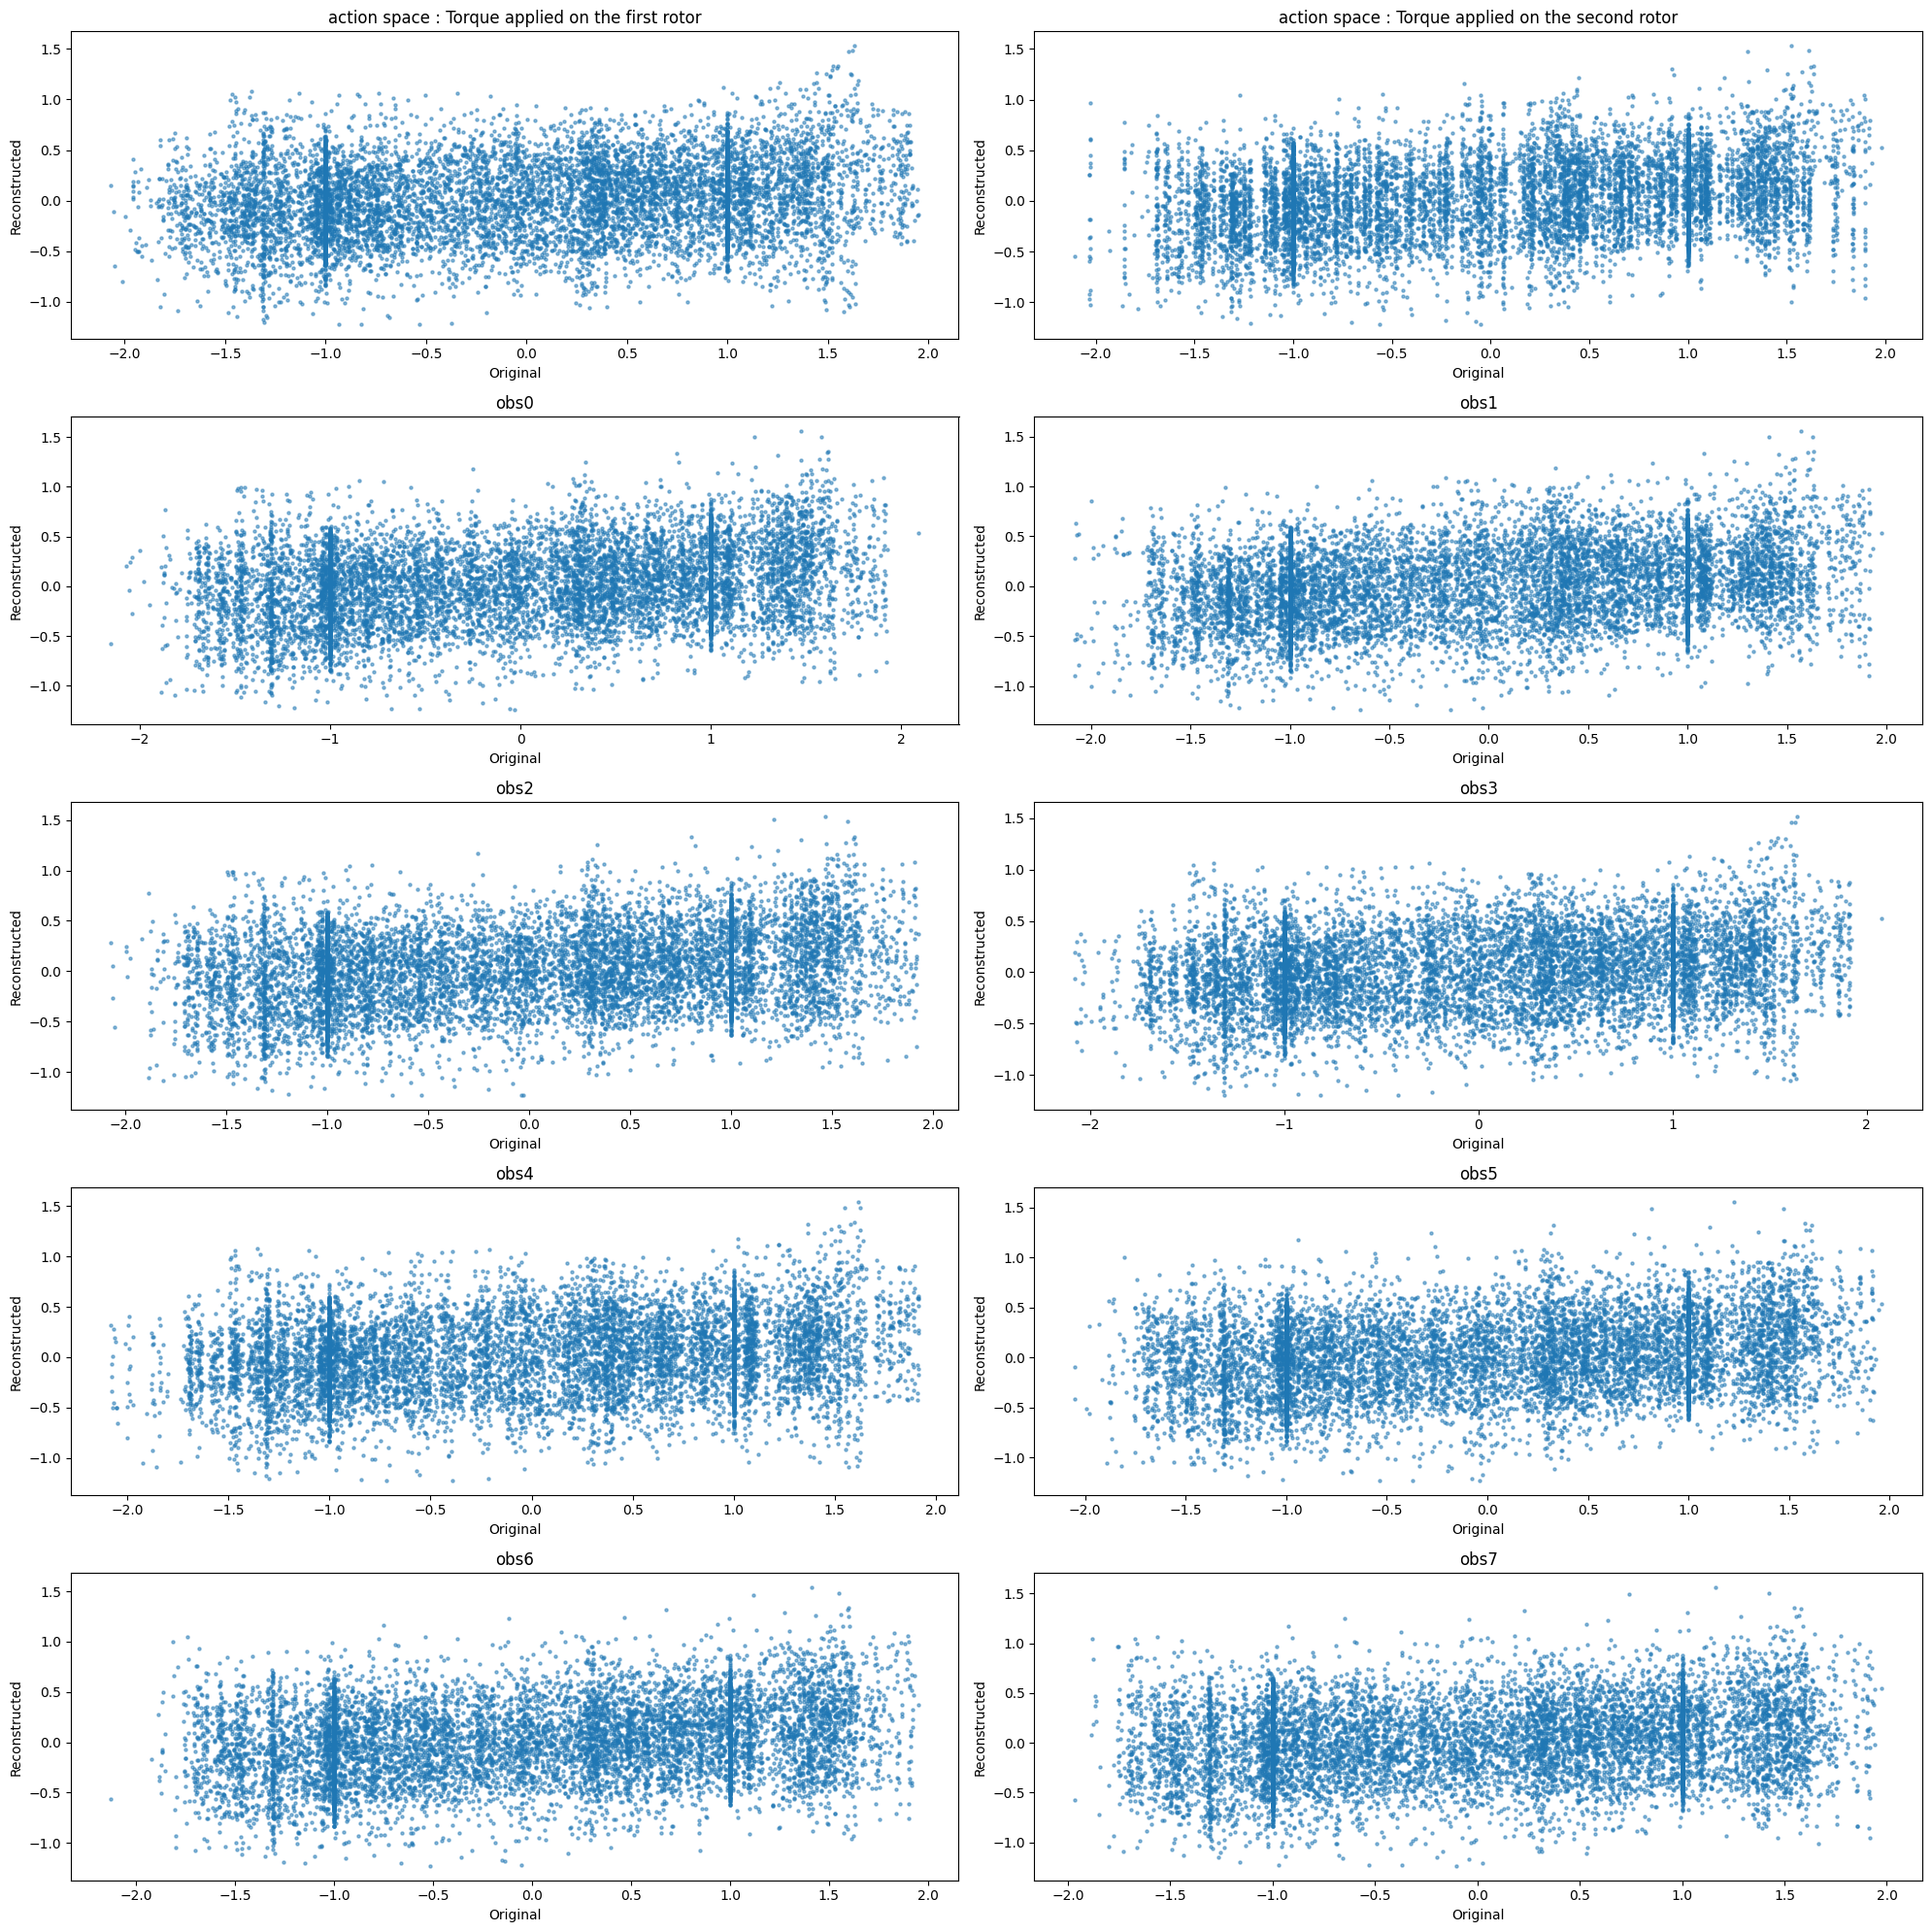

In [26]:
ori_combined_np = label1_original_df.to_numpy()
recon_combined_np = label1_reconstructed_df.to_numpy()

# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[i, :], recon_combined_np[i, :], alpha=0.5, s=5)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
ori_combined_np.shape

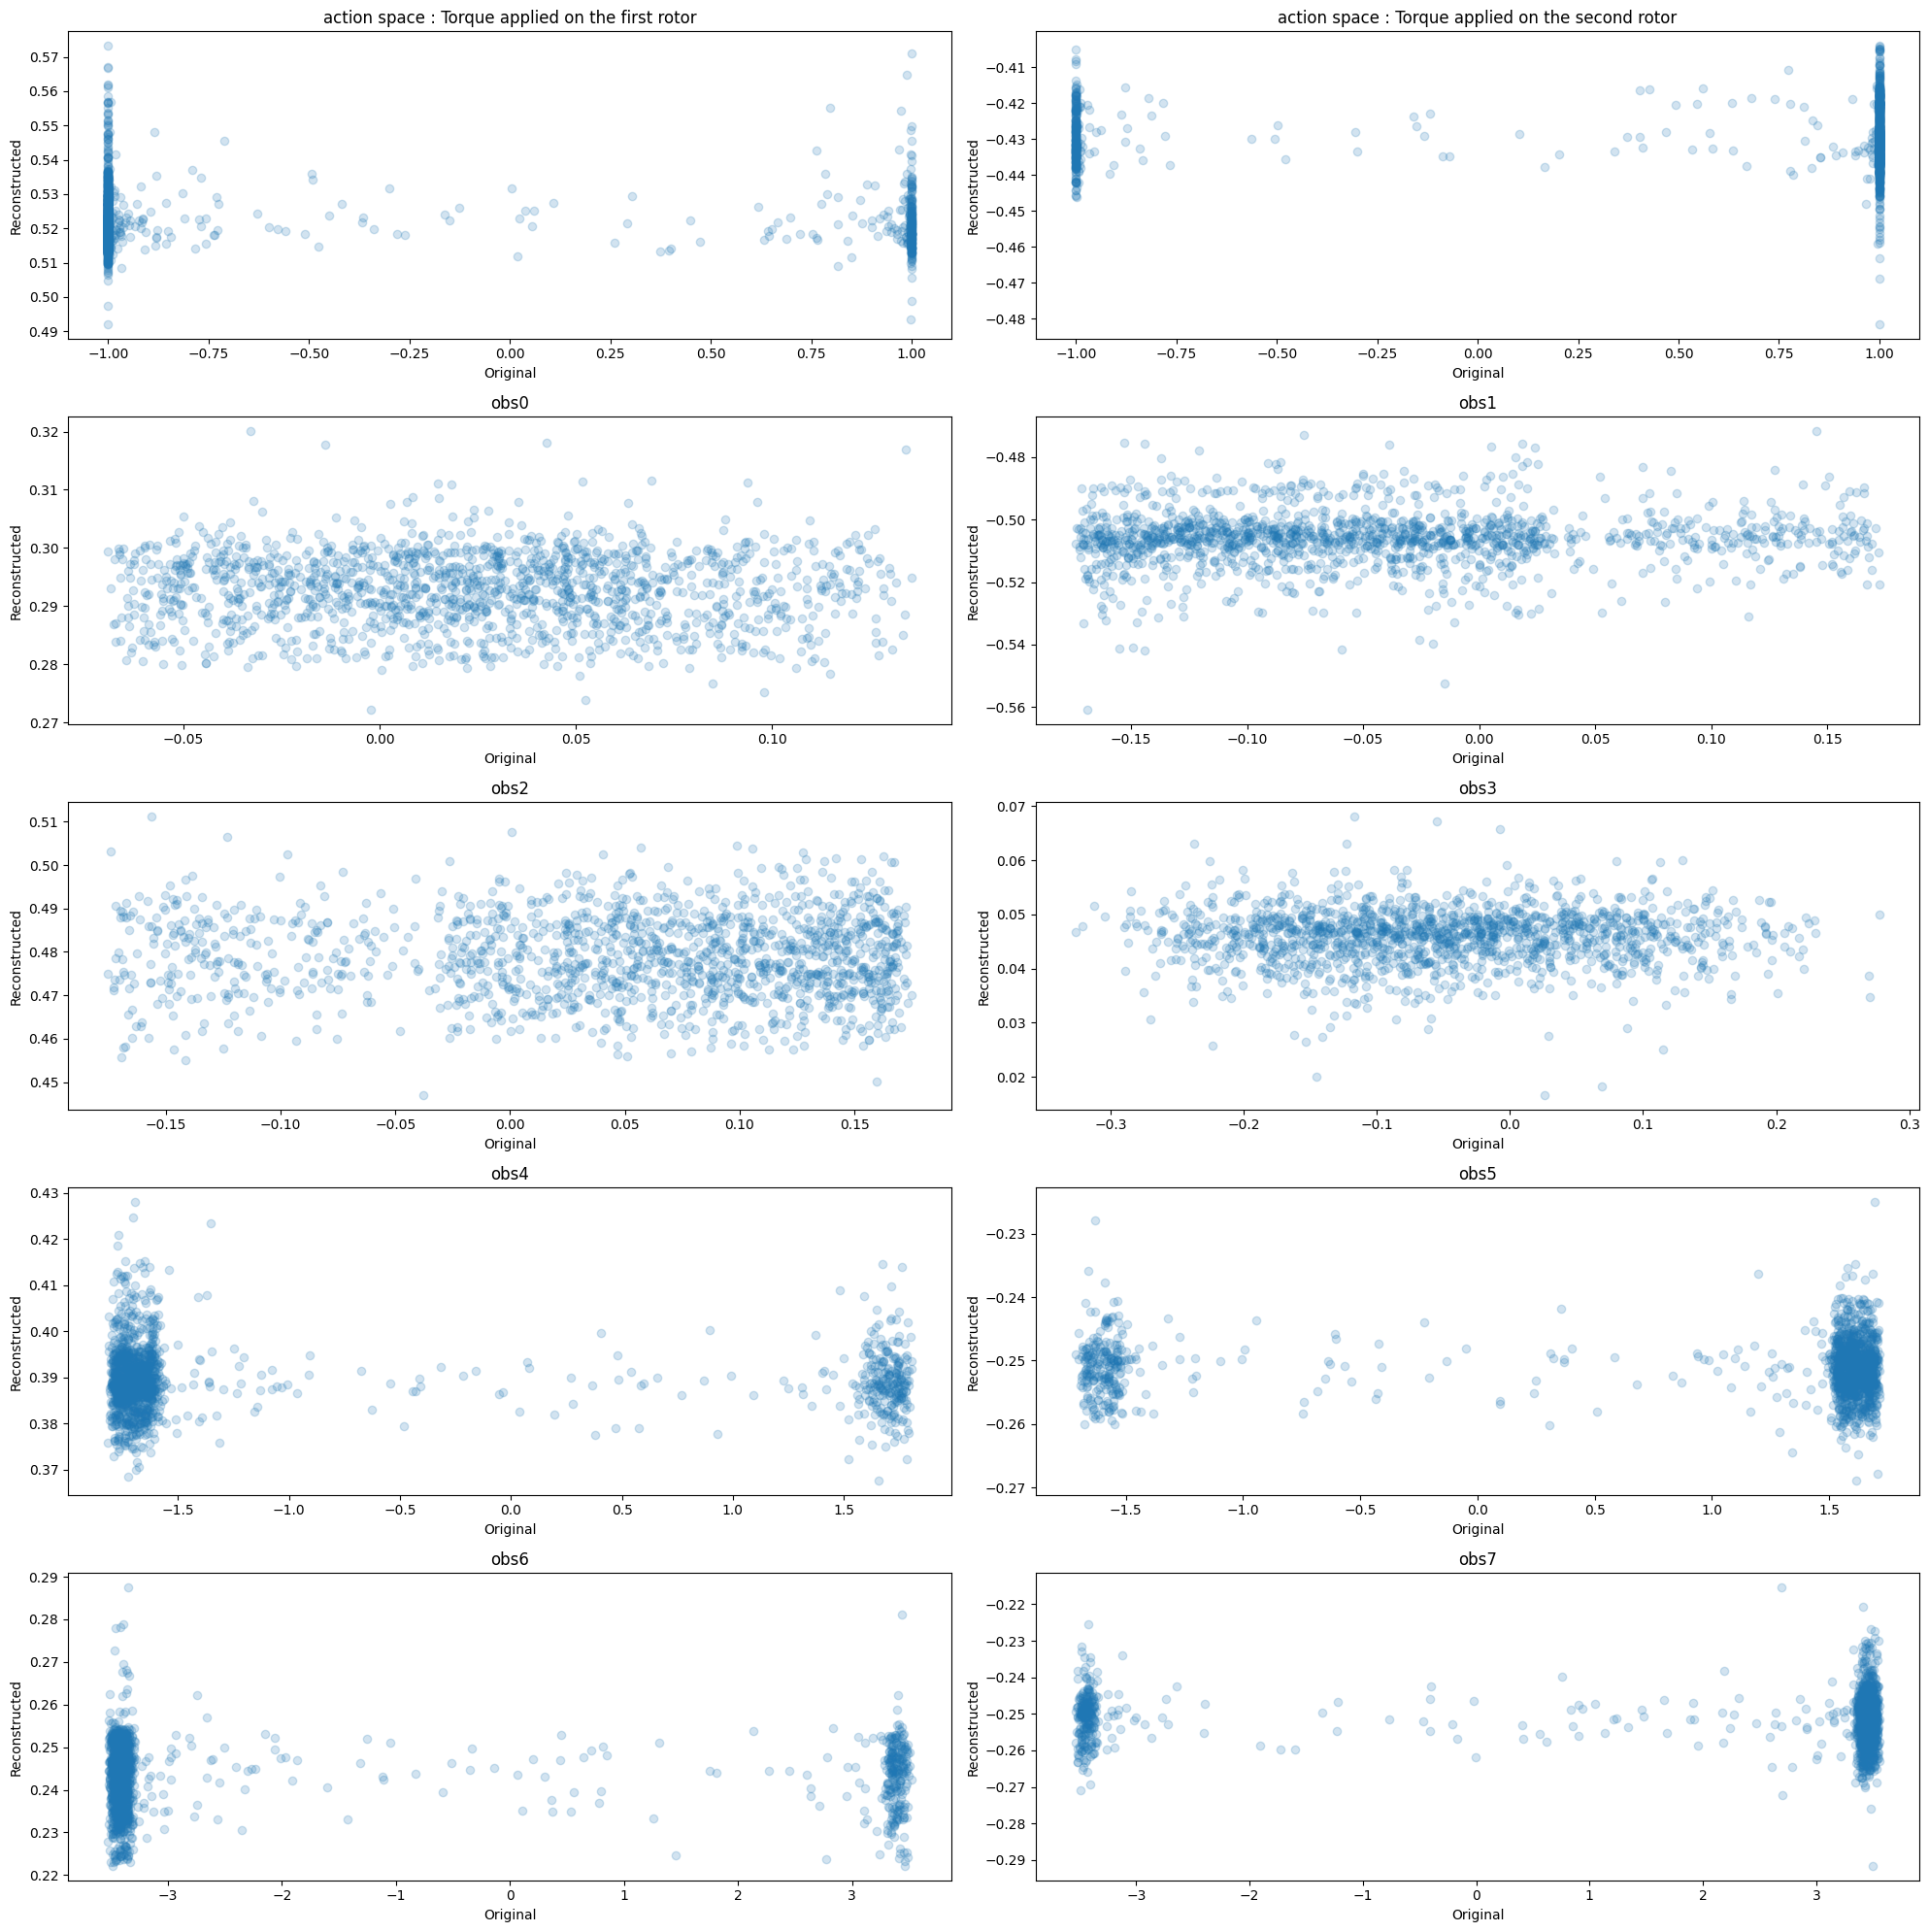

In [18]:
# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[:, i], recon_combined_np[:, i], alpha=0.2)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()
